In [23]:
from selenium import webdriver
from selenium.webdriver.support.select import Select
from selenium.webdriver.common.by import By
import schedule
import time
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow import keras
import numpy as np
from tensorflow.keras.applications.vgg19 import preprocess_input
from scipy import stats
import datetime
import csv
from shutil import copyfile
import cv2
import pytz 
GMT = pytz.timezone('GMT')
import tensorflow_hub as hub
from PIL import Image

In [3]:
model = load_model('models/t_model_1_4.h5', custom_objects={'KerasLayer':hub.KerasLayer})

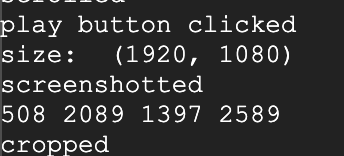

In [30]:
1920/3

640.0

In [27]:
# open falcon cam website
PATH = '/Applications/chromedriver'

# headless
from selenium.webdriver.chrome.options import Options
options = Options()
# options.headless = True
options.add_argument("--window-size=1920x1080")
driver = webdriver.Chrome(PATH, options=options)

# head
# driver = webdriver.Chrome(PATH)

driver.get('https://www.nottinghamshirewildlife.org/peregrine-cam')

elements = driver.find_elements(By.TAG_NAME, 'button')

eu_compliance = driver.find_element(By.ID, 
                                     'popup-buttons')

eu_compliance.find_elements_by_css_selector("*")[0].click()

play_buttons = driver.find_elements(By.CLASS_NAME, 
                                     'vjs-big-play-button')

play_buttons[1].click()
        
# locate video element for screenshotting

video_boxes = driver.find_elements(By.TAG_NAME, 'video')

video_box_1, video_box_2 = video_boxes
        
driver.execute_script("arguments[0].scrollIntoView();", video_box_2)

location = video_box_2.location

size = video_box_2.size

driver.save_screenshot('screenshot.png') # saves screenshot of entire page

im = Image.open('screenshot.png') # uses PIL library to open image in memory

left = location['x']

top = location['y']

right = location['x'] + size['width']

bottom = location['y'] + size['height']

im = im.crop((left, top, right, bottom)) # defines crop points

im.load()

im.save('screenshot.png') # saves new cropped image
        
schedule.clear()

In [28]:
1920/1080

1.7777777777777777

In [21]:
video_box_2.screenshot('live_images/image1.png')

True

In [4]:
# # csv reset
# import pandas as pd
# df = pd.DataFrame(columns = ['status', 'datetime_GMT'])
# df.to_csv('bird_sightings.csv', index = False)
# df.head()

In [5]:
def get_screenshots():
    global video_box_2
    video_box_2.screenshot('live_images/image1.png')
    time.sleep(1)
    video_box_2.screenshot('live_images/image2.png')
    time.sleep(1)
    video_box_2.screenshot('live_images/image3.png')

def is_there_a_bird():
    
    snapshot_time = datetime.datetime.now(GMT)
    get_screenshots()
    
    predictions = []
    for i in ['1', '2', '3']:
        screenshot = image.load_img('live_images/image' + i + '.png', target_size = (224, 224))
        screenshot_array = image.img_to_array(screenshot)
        prep_img = tf.keras.applications.mobilenet_v2.preprocess_input(screenshot_array)
        prediction = np.argmax(model.predict(prep_img[np.newaxis, ...]))
        predictions.append(prediction)
        if prediction == 1:
            copyfile('live_images/image' + i + '.png',
                     'per_imgs/saved_positives/' + 
                      str(snapshot_time).replace(' ', '').replace(':', '-').replace('.', '') + '-' + i + '.png')
        elif prediction == 0:
            copyfile('live_images/image' + i + '.png',
                     'per_imgs/saved_negatives/' + 
                      str(snapshot_time).replace(' ', '').replace(':', '-').replace('.', '') + '-' + i + '.png')

    if stats.mode(predictions)[0][0] == 1:
        status = 'bird'
        
    elif stats.mode(predictions)[0][0] == 0:
        status = 'no bird'
        
    with open('bird_sightings.csv', 'a', newline='') as csvfile:
        status_writer = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        status_writer.writerow([status, snapshot_time])
        
    return status

In [6]:
schedule.every(1).minutes.do(is_there_a_bird)

while True:
    schedule.run_pending()
    time.sleep(1)

KeyboardInterrupt: 